This tutorial is adapted from [Dair-AI Pytorch Geometric Tutorial](https://github.com/dair-ai/GNNs-Recipe) by Elvis Saravia.

### Installing dependencies

In [1]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.3.1+cpu


The installation of PyG can be a little bit tricky. Execute the cell below -- in case of issues, more information can be found on the [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [2]:
# Install dependencies
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
# Install torch geometric
!pip install -q torch-geometric

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

# Loading Data

One of the cool things about the PyTorch Geometric library is that it contains out-of-the-box benchmark datasets that are ready to use and explore. A popular dataset is the Cora dataset that is used for supervised graph node classification.

"The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words." - [Papers with Code](https://paperswithcode.com/dataset/cora).

Let's load the Cora dataset:

In [4]:
dataset = Planetoid(root='tmp/Cora', name='Cora')

Let's check some of the properties of the Cora dataset.

In [5]:
# number of graphs
print("Number of graphs: ", len(dataset))

# number of features
print("Number of features: ", dataset.num_features)

# number of classes
print("Number of classes: ", dataset.num_classes)

Number of graphs:  1
Number of features:  1433
Number of classes:  7


In [6]:
print(dataset[0].edge_index)

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])


We can see that this particular graph dataset only contains one graph. Graph data can be very complex and can include multiple graphs depending on the type of data and application. Let's check more feature of the Cora dataset:

In [7]:
# select the first graph
data = dataset[0]

# number of nodes
print("Number of nodes: ", data.num_nodes)

# number of edges
print("Number of edges: ", data.num_edges)

# check if directed
print("Is directed: ", data.is_directed())

Number of nodes:  2708
Number of edges:  10556
Is directed:  False


You can sample nodes from the graph this way:

In [8]:
# sample nodes from the graph
print("Shape of sample nodes: ", data.x[:5].shape)

Shape of sample nodes:  torch.Size([5, 1433])


We extracted 5 nodes from the graph and checked its shape. You will see that each node has `1433` features.

Another great advantage of using PyTorch Geometric to load the Cora data is that it comes pre-processed and ready to use. It also has the splits for training, validation and test which we can directly use for training a GNN.

Let's check some stats for the partitions of the data:

In [9]:
# check training nodes
print("# of nodes to train on: ", data.train_mask.sum().item())
# check test nodes
print("# of nodes to test on: ", data.test_mask.sum().item())
# check validation nodes
print("# of nodes to validate on: ", data.val_mask.sum().item())

# of nodes to train on:  140
# of nodes to test on:  1000
# of nodes to validate on:  500


That information is important as it will indicate to our model which nodes to train against and which to test against, and so on.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
data = dataset[0].to(device)

cpu


# Model and Training

Finally, let's define a standard GCN to train on the Cora dataset. The aim is to train a model that gets better at predicting the class of the node.

We are using the built-in `GCNConv` model but we could easily implement your own.

The model below uses two `GCNConv` layers. The first layer is followed by a non-linearity `ReLU` and `Dropout`. The result is fed to the second layer on top of which we apply `Softmax` to get distribution over the number of classes.

In [11]:
class GCN(torch.nn.Module):
    
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, x, edge_index):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
        

In [12]:
model = GCN(num_features=data.num_features, num_classes=dataset.num_classes).to(device)

Optimizer:

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

Losss function:

In [14]:
loss_fn = F.nll_loss

And finally we train the model on the training nodes for 200 epochs:

In [15]:
# train the model
model.train()
losses = []
accuracies = []

for epoch in range(200):
    
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    losses.append(loss.item())

    pred = out.argmax(dim=1)[data.train_mask]
    correct = (pred == data.y[data.train_mask]).sum()
    acc = correct / data.train_mask.sum()
    accuracies.append(acc)

    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print('Epoch: {}, Loss: {:.4f}, Training Acc: {:.4f}'.format(epoch+1, loss.item(), acc))


Epoch: 10, Loss: 0.7938, Training Acc: 0.8929
Epoch: 20, Loss: 0.2597, Training Acc: 0.9929
Epoch: 30, Loss: 0.0818, Training Acc: 1.0000
Epoch: 40, Loss: 0.0737, Training Acc: 0.9929
Epoch: 50, Loss: 0.0612, Training Acc: 0.9857
Epoch: 60, Loss: 0.0350, Training Acc: 1.0000
Epoch: 70, Loss: 0.0239, Training Acc: 1.0000
Epoch: 80, Loss: 0.0321, Training Acc: 1.0000
Epoch: 90, Loss: 0.0297, Training Acc: 1.0000
Epoch: 100, Loss: 0.0370, Training Acc: 1.0000
Epoch: 110, Loss: 0.0432, Training Acc: 1.0000
Epoch: 120, Loss: 0.0342, Training Acc: 1.0000
Epoch: 130, Loss: 0.0377, Training Acc: 1.0000
Epoch: 140, Loss: 0.0277, Training Acc: 1.0000
Epoch: 150, Loss: 0.0324, Training Acc: 1.0000
Epoch: 160, Loss: 0.0229, Training Acc: 1.0000
Epoch: 170, Loss: 0.0298, Training Acc: 1.0000
Epoch: 180, Loss: 0.0248, Training Acc: 1.0000
Epoch: 190, Loss: 0.0170, Training Acc: 1.0000
Epoch: 200, Loss: 0.0205, Training Acc: 1.0000


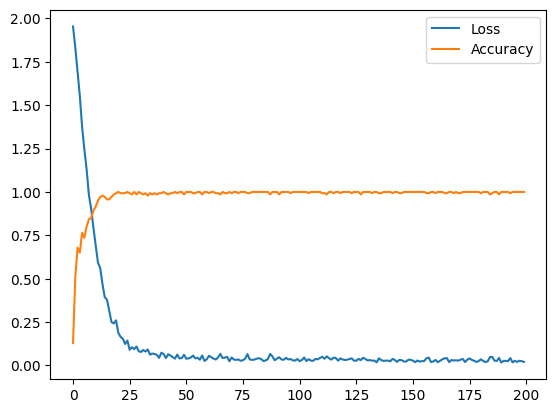

In [16]:
# plot the loss and accuracy
plt.plot(losses)
plt.plot(accuracies)
plt.legend(['Loss', 'Accuracy'])
plt.show()

It looks like the model achieves a very high accuracy and small loss on the training dataset. To see how well it generalizes, let's test on the testing nodes:

In [17]:
# evaluate the model on test set
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = correct / data.test_mask.sum()
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8010


Very cool! It seems we got a very nice accuracy for the test as well. Our model is doing okay. There are many ways you can go about trying to improve this model, but we will keep that for another time. Hopefully, with this tutorial you got a glimpse of graph data and how to use PyTorch Geometric to train GNNs on a very popular dataset. 